In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
from tensorflow.keras.models import Sequential, Model, load_model
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

##  資料讀入及前處理

In [3]:
train_path = "D:/score_0613/"

x_data_train = []
y_data_train = []
for roots, dirs, files in os.walk(train_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_train.append(os.path.join(roots.split("/")[-1], each))
            y_data_train.append(roots.split("/")[-1])

In [4]:
data_train = pd.DataFrame({})
data_train['img_path'] = x_data_train
data_train['label'] = y_data_train

In [5]:
print(len(x_data_train),len(y_data_train))

32608 32608


# 讀入測試資料

In [6]:
# test_path = "c:/word/" #讀入測試資料

# x_data_test = []
# y_data_test = []
# for roots, dirs, files in os.walk(test_path):
#     for each in files:
#         if each.find('checkpoint') == -1:
#             x_data_test.append(os.path.join(roots.split("/")[-1], each))
#             y_data_test.append(roots.split("/")[-1])

In [7]:
# data_test = pd.DataFrame({})
# data_test['img_path'] = x_data_test
# data_test['label'] = y_data_test
# data_test['label'] = data_test['img_path'].str.replace('.png', '')

In [8]:
# print(len(x_data_test),len(y_data_test))

In [9]:
#Label導入
class_map = pd.read_csv('d:/python/class_map_0611.csv', index_col=0) 
class_map = class_map.to_dict()['class']

In [10]:
class_map

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}

In [11]:
# data=data_train.copy()
# ax = data.groupby('label').count().plot(kind='bar', figsize=(10, 5), fontsize=20, legend=False)
# grouped_values = data.groupby('label').count()['img_path'].values
# for idx, value in enumerate(grouped_values):
#     ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
# ax.set_title("TrainData", fontsize=30)
# ax.set_xlabel("", fontsize=14)
# ax.set_ylabel("", fontsize=14)

In [12]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_train,
                                         test_size=0.1,
                                         random_state=35,
                                         stratify=data_train['label'].values)

In [13]:
img_size = 112
num_class = len(data_train['label'].unique())
num_class

8

## 讀入 Pre-trained Model

In [14]:
from tensorflow.keras.applications.xception import (Xception, preprocess_input)

In [15]:
pre_model = Xception(weights=None, include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.25)(x)
outputs = Dense(1, activation='linear')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [16]:
# model.summary()

# 決定 Pre-Train 參數量

In [17]:
pre_model.trainable = True

# trainable_layer = 10
# for layer in pre_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [18]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

In [19]:
batch_size = 64
num_steps = len(train_list) // batch_size + 1
num_epochs = 40

In [20]:
train_datagen = ImageDataGenerator(
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=False,
                                   zoom_range = [1.2,1.2],
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
data_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [21]:
img_shape = (img_size, img_size)
# train data 讀取
train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=train_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='sparse')

# valid_generator = valid_datagen.flow_from_dataframe(
#                                                     dataframe=val_list,
#                                                     directory=None,
#                                                     x_col="img_path",
#                                                     y_col="ll",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical',
#                                                     shuffle=False)


test_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=train_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=False)
# 用在不知道 label 的資料讀取上(自己手寫資料)
# data_test_generator = data_test_datagen.flow_from_dataframe(
#                                                     dataframe=data_test,
#                                                     directory=test_path,
#                                                     x_col="img_path",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode=None,
#                                                     shuffle=False)


Found 29347 validated image filenames belonging to 8 classes.
Found 3261 validated image filenames belonging to 8 classes.


In [22]:
train_list

,img_path,label
18437,5\img4_2974.png,5
18712,5\img4_3220.png,5
11588,3\img2_431.png,3
17626,5\img4_2241.png,5
2428,1\img0_321.png,1
...,...,...
8232,3\img2_1074.png,3
10431,3\img2_3072.png,3
2534,1\img0_3306.png,1
7643,2\img1_543.png,2


In [23]:
for i in train_generator:
    print(i[1])
    break

[0. 7. 4. 4. 5. 4. 4. 5. 4. 5. 2. 0. 0. 4. 6. 3. 6. 0. 4. 3. 7. 1. 6. 5.
 0. 5. 0. 3. 0. 5. 1. 3. 1. 4. 5. 1. 4. 7. 3. 7. 1. 6. 5. 6. 1. 2. 0. 1.
 3. 4. 7. 1. 5. 4. 7. 7. 5. 5. 1. 0. 1. 4. 0. 6.]


In [24]:
for i in test_generator:
    print(i[1])
    break

[3. 5. 4. 0. 6. 1. 6. 4. 4. 4. 0. 4. 5. 4. 0. 0. 4. 3. 2. 7. 1. 3. 0. 0.
 5. 4. 5. 4. 1. 2. 2. 3. 0. 3. 0. 4. 6. 3. 1. 0. 3. 0. 3. 5. 0. 3. 4. 1.
 4. 1. 1. 3. 1. 3. 7. 1. 3. 4. 1. 3. 0. 7. 2. 5.]


## 開始訓練模型

In [25]:
model_dir = 'model-logs/xception_0616'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [27]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              #validation_data=test_generator,
                              callbacks=callbacks_list)

Epoch 1/40
459/459 [==============================] - 88s 191ms/step - loss: 1.1716 - accuracy: 0.1545 41s - lo - ETA: 36s - loss: 1.2462 - accuracy: 0. - ETA: 35s - loss: 1.2438 - accuracy: 0. - ETA: 34s - loss: 1.2408 - a - E
Epoch 2/40
459/459 [==============================] - 89s 193ms/step - loss: 0.9133 - accuracy: 0.1556 37s - loss: 0.9 - ETA: 3 - ETA: 26s - loss: 0.9431 - accuracy: 0.1 - ETA: 26s - loss: 0.9434 - ETA: 22s - loss: 0.9365 - accura - ETA: 20s - loss: 
Epoch 3/40
459/459 [==============================] - 89s 193ms/step - loss: 0.7688 - accuracy: 0.1541s - l
Epoch 4/40
459/459 [==============================] - 89s 193ms/step - loss: 0.6676 - accuracy: 0.1602 1:09 - loss: 0 - ETA: 1:06 - loss: 0.7029 - accuracy - ET - ETA: 55s - loss:
Epoch 5/40
459/459 [==============================] - 89s 193ms/step - loss: 0.6065 - accuracy: 0.1625
Epoch 6/40
459/459 [==============================] - 89s 193ms/step - loss: 0.5413 - accuracy: 0.1657: 15s - loss: 0.54 - ETA: 11

459/459 [==============================] - 90s 195ms/step - loss: 0.0922 - accuracy: 0.2350s - loss: 0.0929 - accu - ETA: 3s - loss: 0.0 - ETA: 1s - loss: 0.092
Epoch 33/40
459/459 [==============================] - 90s 195ms/step - loss: 0.0963 - accuracy: 0.2355
Epoch 34/40
459/459 [==============================] - 90s 195ms/step - loss: 0.0944 - accuracy: 0.2365
Epoch 35/40
459/459 [==============================] - 90s 195ms/step - loss: 0.0905 - accuracy: 0.2357s - loss: 0.090
Epoch 36/40
459/459 [==============================] - 90s 195ms/step - loss: 0.0875 - accuracy: 0.2364
Epoch 37/40
459/459 [==============================] - 89s 195ms/step - loss: 0.0754 - accuracy: 0.2378 34s - loss: 0.0803 - accuracy: 0.
Epoch 38/40
459/459 [==============================] - 89s 194ms/step - loss: 0.0840 - accuracy: 0.2374
Epoch 39/40
459/459 [==============================] - 89s 194ms/step - loss: 0.0761 - accuracy: 0.2383
Epoch 40/40
459/459 [==============================] - 89s 194

## 訓練結果視覺化

In [28]:
model_resnet = load_model('d:/python/model-logs/xception_0616/basic_model-best-model.h5')



In [29]:
test_path = "d:/test/" #讀入測試資料

x_data_test = []
y_data_test = []
for roots, dirs, files in os.walk(test_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_test.append(os.path.join(roots.split("/")[-1], each))
            y_data_test.append(roots.split("/")[-1])

In [30]:
data_test = pd.DataFrame({})
data_test['img_path'] = x_data_test
data_test['label'] = y_data_test
data_test['label'] = data_test['img_path'].str.replace('.png', '')

C:\ProgramData\Anaconda3\envs\tf_night\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [31]:
data_test_generator = data_test_datagen.flow_from_dataframe(
                                                    dataframe=data_test,
                                                    directory=test_path,
                                                    x_col="img_path",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False)


Found 18 validated image filenames.


In [32]:
data_test

,img_path,label
0,人1.png,人1
1,人2.png,人2
2,人3.png,人3
3,學1.png,學1
4,學2.png,學2
5,學3.png,學3
6,工1.png,工1
7,工2.png,工2
8,工3.png,工3
9,慧1.png,慧1


In [33]:
#class_name = test_generator.class_indices

In [34]:
#class_name_remap = dict(zip(class_name.values(), class_name.keys()))

In [35]:
y_pred = model_resnet.predict_generator(data_test_generator)
#y_pred_final = pd.DataFrame(y_pred.argmax(-1),columns=['label'])
#y_pred_final = y_pred_final['label'].map(class_name_remap).map(class_map)
#y_pred_final
y_pred

C:\ProgramData\Anaconda3\envs\tf_night\lib\site-packages\tensorflow\python\keras\engine\training.py:2011: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0.23373039],
       [2.1999724 ],
       [1.2830508 ],
       [1.2575865 ],
       [2.0785387 ],
       [1.8852414 ],
       [4.0488653 ],
       [2.0063617 ],
       [0.08841573],
       [3.1849113 ],
       [2.1346738 ],
       [1.9487356 ],
       [3.774294  ],
       [2.0985925 ],
       [0.1900224 ],
       [4.056319  ],
       [2.0704195 ],
       [0.80519664]], dtype=float32)

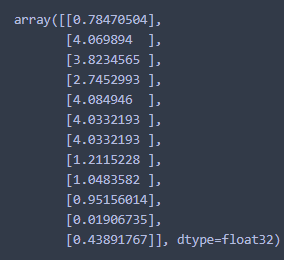
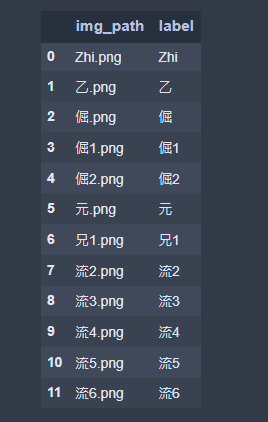